# Chapter 11: Training Deep Neural Networks

In [1]:
# Libraries

import sklearn
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os

np.random.seed(42)

# Plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## 1. Activations

### 1.1 Vanishing and Exploding Gradients

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

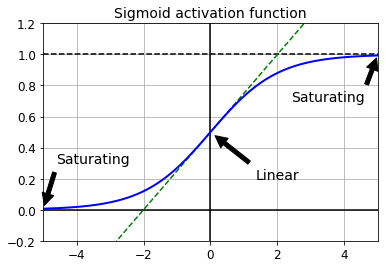

In [3]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

### 1.2 Xavier-He Initialization

- _Idea_ : want variance of outputs to be approximately equal to variance of inputs (before/after flow in backprop)

- The following holds for the sigmoid initialization:

$$\mathrm{Glorot \; normal \; init} \sim \mathcal{N} \bigg(0, \, \frac{2}{a^{[\ell]} + a^{[\ell - 1]}} \bigg)$$
$$\mathrm{Glorot \; uniform \; init} \sim U \bigg[-\sqrt{\frac{6}{a^{[\ell]} + a^{[\ell - 1]}}} , \, \sqrt{\frac{6}{a^{[\ell]} + a^{[\ell - 1]}}} \bigg]$$

For $a_{\mathrm{avg}} = \frac{a^{[\ell]} + a^{[\ell - 1]}}{2}$, have:
   - __Glorot__ : for tanh, logistic, softmax -- $\sigma^2 = \frac{1}{a_{\mathrm{avg}}}$
   - __He__ : for ReLU -- $\sigma^2 = \frac{2}{a^{[\ell - 1]}}$

In [4]:
# List of initializations

[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [6]:
# By default, Karas uses Glorot uniform
# Can change to He:

keras.layers.Dense(10, activation = "relu", kernel_initializer = "he_normal")

In [7]:
# Can manually adjust He based on average rather than input dimension:

init = keras.initializers.VarianceScaling(scale = 2.0, mode = "fan_avg", distribution = "uniform")
keras.layers.Dense(10, activation = "relu", kernel_initializer = init)

### 1.3 Nonsaturating Activation Functions

#### 1.3.1 Leaky ReLU

- Problem with ReLU: activations "die" because of 0 derivative on the left
- Neuron dies when weighted sum of inputs negative for all instances in training set -- will be unaltered by GD!
- Attempt to solve by leaky ReLU: $\mathrm{LeakyReLU}_{\alpha}(z) = \max(\alpha z, \, z)$

__Notes__ :
   - Typically, large leak $\alpha = 0.2$ might do better than small $\alpha = 0.01$
   - _Randomized leaky ReLU_ : RRELU -- choose $\alpha$ at random during trainign, and fix to average value during test
   - _Parameterized leaky ReLU_ : PReLU -- learn $\alpha$ during training (works well on large datasets)

In [8]:
def leaky_relu(z, alpha = 0.01):
    return np.maximum(alpha*z, z)

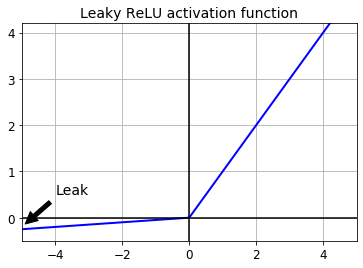

In [9]:
# Plot the leaky ReLU

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

In [10]:
# List of built-in activations

[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [11]:
# List of ReLU variants

[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

In [12]:
# Example: fashion MNIST using leaky ReLU

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [13]:
# Toy network

tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dense(300, kernel_initializer = "he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer = "he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation = "softmax")
])

In [14]:
model.compile(loss = "sparse_categorical_crossentropy",
             optimizer = keras.optimizers.SGD(lr = 1e-3),
             metrics = ["accuracy"])

In [15]:
history = model.fit(X_train, y_train, epochs = 10,
                   validation_data = (X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 2s 930us/step - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 2s 879us/step - loss: 0.7955 - accuracy: 0.7362 - val_loss: 0.7130 - val_accuracy: 0.7656
Epoch 3/10
1719/1719 [==============================] - 2s 906us/step - loss: 0.6816 - accuracy: 0.7721 - val_loss: 0.6427 - val_accuracy: 0.7900
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6217 - accuracy: 0.7944 - val_loss: 0.5900 - val_accuracy: 0.8066
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5832 - accuracy: 0.8074 - val_loss: 0.5582 - val_accuracy: 0.8198
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5553 - accuracy: 0.8157 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5338 - accuracy: 0.8224 - val_loss: 0.5157 - val_acc

#### 1.3.2 PReLU

In [16]:
# Learn alpha factor through training

tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dense(300, kernel_initializer = "he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer = "he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation = "softmax")
])

In [17]:
model.compile(loss = "sparse_categorical_crossentropy",
             optimizer = keras.optimizers.SGD(lr = 1e-3),
             metrics = ["accuracy"])

In [18]:
history = model.fit(X_train, y_train, epochs = 10,
                   validation_data = (X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 1.3461 - accuracy: 0.6209 - val_loss: 0.9255 - val_accuracy: 0.7186
Epoch 2/10
1719/1719 [==============================] - 2s 988us/step - loss: 0.8197 - accuracy: 0.7355 - val_loss: 0.7305 - val_accuracy: 0.7630
Epoch 3/10
1719/1719 [==============================] - 2s 968us/step - loss: 0.6965 - accuracy: 0.7694 - val_loss: 0.6564 - val_accuracy: 0.7882
Epoch 4/10
1719/1719 [==============================] - 2s 972us/step - loss: 0.6330 - accuracy: 0.7908 - val_loss: 0.6003 - val_accuracy: 0.8048
Epoch 5/10
1719/1719 [==============================] - 2s 955us/step - loss: 0.5917 - accuracy: 0.8056 - val_loss: 0.5656 - val_accuracy: 0.8182
Epoch 6/10
1719/1719 [==============================] - 2s 959us/step - loss: 0.5618 - accuracy: 0.8135 - val_loss: 0.5406 - val_accuracy: 0.8236
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5390 - accuracy: 0.8205 - val_loss: 0.5196 - val

#### 1.3.3 ELU

- "ELU" = exponential linear unit

$$\mathrm{ELU}_{\alpha}(z) = \begin{cases} \alpha \cdot (\exp(z) - 1) & \text{if } z < 0 \\ z & \text{if } z \geq 0\end{cases}$$

- __Pros__ :
   - Solves nonzero gradient for $z < 0$ like ReLU
   - For $\alpha = 1$, is smooth everywhere
   - Faster training convergence
   
- __Cons__ :
   - Slower to compute than ReLU
   - Slower at test time

In [19]:
# ELU function

def elu(z, alpha = 1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

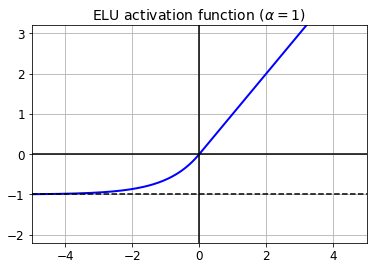

In [20]:
# ELU plot

plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [21]:
# Can specify ELU function when building layers in tf

keras.layers.Dense(10, activation = "elu")

#### 1.3.4 SELU

- "SELU" : scaled ELU

- __Pros__ :
    - Building Dense-only NN with SELUs preserves mean 0 and sd 1 throughout traning (_self-normalization_)
    - Significantly outperforms other activations in dense, deep NNs
    - Need: input features standardized to std normal, weights init with LeCun normal, and MUST have sequential architecture
    - Can sometimes help in sequential CNNs
- __Cons__ :
    - Very specific use case
    - CANNOT use L1 or L2 regularization!!
    - Also can't use: regular dropout, max-norm, skip connections, or non-sequential topologies

In [22]:
# Make selu function params

from scipy.special import erfc

# alpha and scale to self-normalize with mean 0, sd 1

alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [23]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

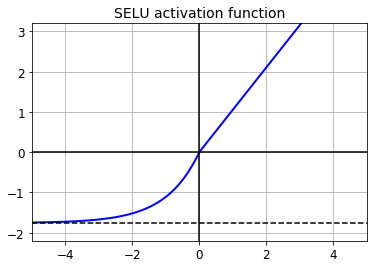

In [24]:
# Plot

plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [25]:
# Implement SELU NN

np.random.seed(42)
Z = np.random.normal(size = (500, 100)) # standardized inputs

for layer in range(1000):
    W = np.random.normal(size = (100, 100), scale = np.sqrt(1 / 100)) # LeCun init
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis = 0).mean()
    stds = np.std(Z, axis = 0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


In [26]:
# keras selu

keras.layers.Dense(10, activation = "selu", kernel_initializer = "lecun_normal")

In [27]:
# Try NN for fashion MNIST with 100 hidden layers using selu!

np.random.seed(42)
tf.random.set_seed(42)

In [28]:
# Build the model

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [28, 28]))
model.add(keras.layers.Dense(300, activation = "selu", kernel_initializer = "lecun_normal"))

for layer in range(99):
    model.add(keras.layers.Dense(100, activation = "selu", kernel_initializer = "lecun_normal"))
    
model.add(keras.layers.Dense(10, activation = "softmax"))

In [29]:
model.compile(loss = "sparse_categorical_crossentropy",
             optimizer = keras.optimizers.SGD(lr = 1e-3),
             metrics = ["accuracy"])

In [30]:
# Scale the training set

pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [32]:
# Train

history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 13s 8ms/step - loss: 0.9940 - accuracy: 0.6219 - val_loss: 0.7349 - val_accuracy: 0.7082
Epoch 2/5
1719/1719 [==============================] - 13s 7ms/step - loss: 0.6785 - accuracy: 0.7460 - val_loss: 0.5819 - val_accuracy: 0.7848
Epoch 3/5
1719/1719 [==============================] - 13s 7ms/step - loss: 0.5810 - accuracy: 0.7845 - val_loss: 0.5928 - val_accuracy: 0.7776
Epoch 4/5
1719/1719 [==============================] - 13s 7ms/step - loss: 0.5363 - accuracy: 0.8053 - val_loss: 0.4840 - val_accuracy: 0.8248
Epoch 5/5
1719/1719 [==============================] - 13s 7ms/step - loss: 0.5355 - accuracy: 0.8129 - val_loss: 0.4743 - val_accuracy: 0.8404


In [33]:
# Contrast this with a normal ReLU with 100 layers

np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])

history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid)) # worse performance!!

Epoch 1/5
1719/1719 [==============================] - 12s 7ms/step - loss: 1.8779 - accuracy: 0.2445 - val_loss: 1.3530 - val_accuracy: 0.3936
Epoch 2/5
1719/1719 [==============================] - 11s 7ms/step - loss: 1.1823 - accuracy: 0.4929 - val_loss: 0.8976 - val_accuracy: 0.6058
Epoch 3/5
1719/1719 [==============================] - 12s 7ms/step - loss: 1.0236 - accuracy: 0.5790 - val_loss: 0.9645 - val_accuracy: 0.6104
Epoch 4/5
1719/1719 [==============================] - 11s 7ms/step - loss: 0.8173 - accuracy: 0.6759 - val_loss: 0.7479 - val_accuracy: 0.7156
Epoch 5/5
1719/1719 [==============================] - 11s 7ms/step - loss: 0.7356 - accuracy: 0.7219 - val_loss: 0.7024 - val_accuracy: 0.7348


## 2. Batch Norm